# ⛓ Metal Orders Automation System

This notebook implements an end-to-end system for automating the processing
 of customer orders for metal products in Spanish. It matches informal customer
 queries to specific SKUs in a product catalog.

> 🔸 System overview:
- Transforms customer queries in Spanish into structured product orders
- Maps informal descriptions to specific catalog SKUs
- Extracts quantities, dimensions, and material specifications

> 🔸Technical components:
- Universal Sentence Encoder (multilingual) for 512-dimension embeddings
- FAISS vector database with L2 distance for efficient similarity search
- Llama-3.3-70B-Instruct-Turbo-Free LLM for advanced reasoning
- Hybrid scoring with weighted attribute matching
- Regular expression pattern matching for product specifications

# Installing dependencies and imports

In [ ]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 762.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 23.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


✋ Due to dependency conflicts of certain libraries used by langchain and pandas I had to use this specific version of numpy so that all libraries run smoothly

🚨 After running this cell please disconnect or restart runtime and run the cells below 🔽

In [ ]:
!pip install together langchain langchain_community scikit-learn faiss-cpu transformers tensorflow-hub tqdm googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of langsmith to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langsmith to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with strict

In [ ]:
import os
import pandas as pd
import numpy as np
from langchain_community.embeddings import TensorflowHubEmbeddings
from langchain_community.vectorstores import FAISS
from together import Together
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from tqdm.notebook import tqdm
import json
import time
from googletrans import Translator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Together API Setup
# @markdown Enter your Together.ai API key
api_key = "50d5f1a5f54d228ac8c2424882321d24a545715db8233037210cc40cc5b81f36" # @param {type:"string"}

if api_key:
    os.environ["API_KEY"] = api_key
    print("API key set!")
else:
    print("Please enter a valid API key")

API_KEY = os.getenv("API_KEY")
EMBEDDING_MODEL = "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/multilingual/versions/2"
LLM_MODEL = "meta-llama/Llama-3.3-70B-Instruct-Turbo-Free"
DB_PATH = 'catalog_vectorstore'

API key set!


#Setup and Initialization

In [ ]:
print("Initializing translator...")
translator = Translator()

def translate_text(text, src='es', dest='en'):
    """Translate text from source language to destination language"""
    if not isinstance(text, str) or not text.strip():
        return text

    try:
        translation = translator.translate(text, src=src, dest=dest)
        return translation.text
    except Exception as e:
        print(f"Translation error: {e}")
        return text  # Return original text if translation fails


def translate_dataframe(df, columns, src='es', dest='en'):
    """Translate specified columns in a dataframe"""
    translated_df = df.copy()

    for col in columns:
        if col in translated_df.columns:
            print(f"Translating column: {col}")
            translated_df[f'{col}_translated'] = translated_df[col].apply(
                lambda x: translate_text(str(x), src=src, dest=dest) if pd.notnull(x) else x
            )

    return translated_df

spanish_text = "Hola, ¿cómo estás?"
translated_text = translate_text(spanish_text)
print("Translated text:", translated_text)

Initializing translator...
Translated text: Hello how are you?


In [ ]:
# Test Together.ai client
print("Testing Together.ai client...")
def test_client():
    """Test if the Together.ai client is working"""
    try:
        client = Together(api_key=API_KEY)
        model_name = "meta-llama/Llama-3.3-70B-Instruct-Turbo-Free"
        messages = [
            {"role": "system", "content": "You are a helpful assistant"},
            {"role": "user", "content": "What is the capital of Britain?"}
        ]

        response = client.chat.completions.create(
            messages=messages,
            temperature=0.5,
            top_k=100,
            top_p=0.9,
            repetition_penalty=1.05,
            model=model_name
        )

        response_text = response.choices[0].message.content
        print('LLM response: ', response_text)
        if "london" in response_text.lower():
            print('Together.ai API test passed!')
            return True
        else:
            print('API response received but unexpected content')
            return False
    except Exception as e:
        print(f"API test failed: {e}")
        return False

# Test embedding model
print("Testing embedding model...")
def test_embedding():
    """Test if the embedding model is working"""
    try:
        embedding_function = TensorflowHubEmbeddings(model_url=EMBEDDING_MODEL)
        test_embedding = embedding_function.embed_query("test")
        print(f"Embedding shape: {len(test_embedding)}")
        print("Embedding test passed!")
        return True
    except Exception as e:
        print(f"Embedding test failed: {e}")
        return False

# Run the tests
together_client_works = test_client()
embedding_works = test_embedding()

Testing Together.ai client...
Testing embedding model...
LLM response:  The capital of Britain is London.
Together.ai API test passed!
Embedding shape: 512
Embedding test passed!


In [ ]:
# @title Load and Explore Data
BASE_PATH = '/content/drive/MyDrive/EDISS/Internship/Iconicchain_data/' #@param {type:"string"}

def load_data():
    """Load the catalog and queries data"""
    catalog_df = pd.read_csv(f'{BASE_PATH}catalog.csv')
    queries_df = pd.read_csv(f'{BASE_PATH}queries.csv')

    try:
        examples_df = pd.read_csv(f'{BASE_PATH}examples.csv')
        print(f"Examples shape: {examples_df.shape}")
    except:
        examples_df = None
        print("examples.csv not found or couldn't be loaded")

    try:
        answers_df = pd.read_csv(f'{BASE_PATH}answers.csv')
        print(f"Answers shape: {answers_df.shape}")
    except:
        answers_df = None
        print("answers.csv not found or couldn't be loaded")

    print(f"Catalog shape: {catalog_df.shape}")
    print(f"Queries shape: {queries_df.shape}")

    return catalog_df, queries_df, examples_df, answers_df

# Load data
catalog_df, queries_df, examples_df, answers_df = load_data()

# Display sample data
print("\nCatalog Sample:")
display(catalog_df.head())

print("\nQueries Sample:")
display(queries_df.head())

if examples_df is not None:
    print("\nExamples Sample:")
    display(examples_df.head())

Examples shape: (4, 12)
Answers shape: (289, 12)
Catalog shape: (893, 2)
Queries shape: (273, 2)

Catalog Sample:


,sku,description
0,3L11201010,ANGULOS 20x10x1 A-304 2B
1,3L11202010,ANGULOS 20x20x1 A-304 2B
2,3L11202015,"ANGULOS 20x20x1,5 A-304 2B"
3,271402002003,ANGULOS 20x20x3 A-304 L.C.
4,275402002003,ANGULOS 20x20x3 A-316 L.C.



Queries Sample:


,query,Unnamed: 1
0,"angulo inox a304 20x20x3mm= 24 mts,",NaN
1,"1 angulo 25x25x1.5 aisi 304 lc,",NaN
2,"angulo inox a304 25x25x3mm = 24 mts, lc",NaN
3,ANGULO l.c. AISI304 25X25X3 MM,NaN
4,1 ud angulo en acero inoxidable de 316 de x 25...,NaN



Examples Sample:


,query,answer,description,sku,original_request,description.1,sku.1,items_count,mass_units,length_units,length,mass
0,"angulo inox a304 20x20x3mm= 24 mts,",ANGULOS 20x20x3 A-304 L.C.,ANGULOS 20x20x3 A-304 L.C.,271402002003,"angulo inox a304 20x20x3mm= 24 mts,",angulos 20x20x3 a-304 l.c.,271402002003,1,NaN,m,24.0,NaN
1,"15 chapas aisi 304 2b + pvc de 3000x1500x1,5,","CHAPA INOX. 3000x1500x1,5 A304 2B + PVC","CHAPA INOX. 3000x1500x1,5 A304 2B + PVC",111P30150015,"15 chapas aisi 304 2b + pvc de 3000x1500x1,5,","chapa inox. 3000x1500x1,5 a304 2b + pvc",111p30150015,15,NaN,NaN,NaN,NaN
2,"5 chapas de 3000x1500x1,5 en aisi-304 2b+pvc,","CHAPA INOX. 3000x1500x1,5 A304 2B + PVC","CHAPA INOX. 3000x1500x1,5 A304 2B + PVC",111P30150015,"5 chapas de 3000x1500x1,5 en aisi-304 2b+pvc,","chapa inox. 3000x1500x1,5 a304 2b + pvc",111p30150015,5,NaN,NaN,NaN,NaN
3,1 TUBO 80X40X3 AISI 304,TUBO INOX. 80x40x3 A304 CS,TUBO INOX. 80x40x3 A304 CS,351108004030,1 tubo 80x40x3 aisi 304,tubo inox. 80x40x3 a304 cs,351108004030,1,NaN,NaN,NaN,NaN


In [ ]:
# @title Translate Sample Data
# Translating a few samples for better understanding
if 'catalog_df' in locals() and len(catalog_df) > 0:
    print("\nTranslated Catalog Sample:")
    catalog_sample = catalog_df.head(3)
    translated_catalog = translate_dataframe(catalog_sample, ['description'])
    display(translated_catalog[['sku', 'description', 'description_translated']])

if 'queries_df' in locals() and len(queries_df) > 0:
    print("\nTranslated Queries Sample:")
    queries_sample = queries_df.head(3)

    # Check actual column names
    query_column = 'query' if 'query' in queries_df.columns else queries_df.columns[0]

    translated_queries = translate_dataframe(queries_sample, [query_column])
    display_cols = [query_column, f'{query_column}_translated']
    display(translated_queries[display_cols])


Translated Catalog Sample:
Translating column: description


,sku,description,description_translated
0,3L11201010,ANGULOS 20x10x1 A-304 2B,Angles 20x10x1 A-304 2b
1,3L11202010,ANGULOS 20x20x1 A-304 2B,Angulos 20x20x1 A-304 2b
2,3L11202015,"ANGULOS 20x20x1,5 A-304 2B",Angulos 20x20x1.5 A-304 2b



Translated Queries Sample:
Translating column: query


,query,query_translated
0,"angulo inox a304 20x20x3mm= 24 mts,","Inox A304 20x20x3mm = 24 meters,"
1,"1 angulo 25x25x1.5 aisi 304 lc,","1 angle 25x25x1.5 Aisi 304 LC,"
2,"angulo inox a304 25x25x3mm = 24 mts, lc","Inox angle A304 25x25x3mm = 24 meters, Lc"


In [ ]:
def analyze_catalog_data(catalog_df):
    """Analyze the catalog data to get a better understanding of its structure"""
    print(f"Catalog has {len(catalog_df)} entries with {catalog_df.columns.size} columns")

    # Check for missing values
    missing_values = catalog_df.isnull().sum()
    print("\nMissing values per column:")
    print(missing_values[missing_values > 0])

    # Analyze text lengths
    catalog_df['description_length'] = catalog_df['description'].str.len()

    plt.figure(figsize=(10, 6))
    sns.histplot(catalog_df['description_length'], bins=50)
    plt.title('Distribution of Description Lengths')
    plt.xlabel('Character Count')
    plt.ylabel('Frequency')
    plt.show()

    # Find common patterns in the descriptions
    # Extract most common words
    all_text = ' '.join(catalog_df['description'].fillna(''))
    words = re.findall(r'\w+', all_text.lower())
    word_freq = pd.Series(words).value_counts().head(20)

    print("\nMost common words in catalog descriptions:")
    print(word_freq)

    # Analyze SKU patterns
    sku_patterns = catalog_df['sku'].str.extract(r'([A-Za-z0-9]+)([0-9]+)')
    sku_patterns.columns = ['prefix', 'number']

    print("\nSKU prefix distribution:")
    print(sku_patterns['prefix'].value_counts())

    return word_freq, sku_patterns

Catalog has 893 entries with 2 columns

Missing values per column:
Series([], dtype: int64)


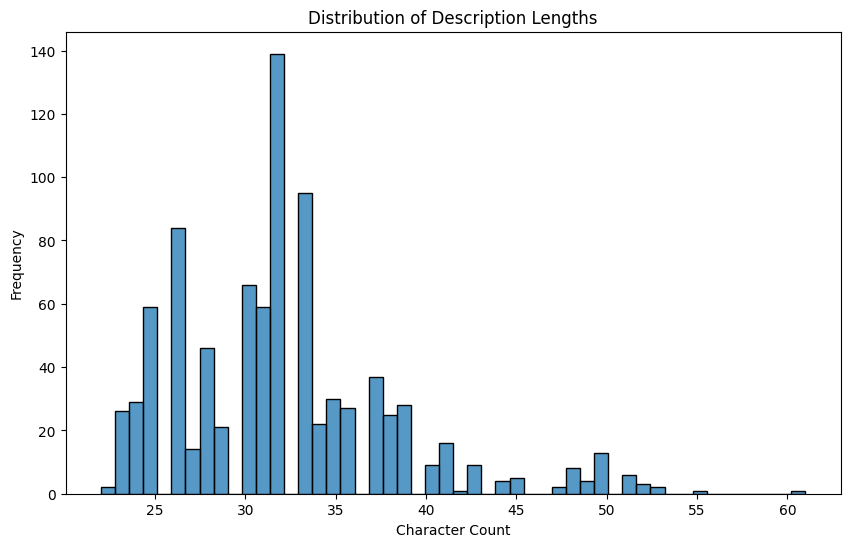


Most common words in catalog descriptions:
inox       792
a304       371
chapa      316
tubo       225
2b         208
a          176
5          156
a316       152
de         144
redondo    125
pvc        122
pletina    112
304        107
pulido      91
lc          67
a316l       62
satin       62
a304l       56
316         50
cs          49
Name: count, dtype: int64

SKU prefix distribution:
prefix
22111          5
24140400       4
24120400       4
34110401       4
24520400       4
              ..
11544015012    1
11144015015    1
11544015015    1
11114015002    1
34130805       1
Name: count, Length: 773, dtype: int64


In [ ]:
word_freq, sku_patterns = analyze_catalog_data(catalog_df)

> 🔸Material & Product Types:
*   Inox (stainless steel) is very common (792 occurrences)
*   Material grades such as a304 and a316 appear frequently (371 and 152 occurrences, respectively)
*   Key product types include chapa (sheet metal), tubo (tube), redondo (round), and pletina (flat bar).

> 🔸Finishes & Properties:
*   The 2b finish is prevalent (208 occurrences).
*   Other common finishes include pulido (polished) and satin.
*   PVC appears in 122 descriptions, likely indicating a coating or cover.

> 🔸SKU Patterns:

> There are 773 unique SKU prefixes among 893 items, showing no dominant pattern.This implies that matching based on content (product type, material, finishes, dimensions) is more effective than relying on SKU prefix patterns.
Thus, based on these findings, the matching algorithm should focus on correctly identifying product type, material grade, and dimensions, as these features are the most distinctive in the catalog. Surface finishes should also be taken into account, while simple prefix matching for SKUs is unlikely to be reliable.


Analyzing query patterns:
Query dataset has 273 entries


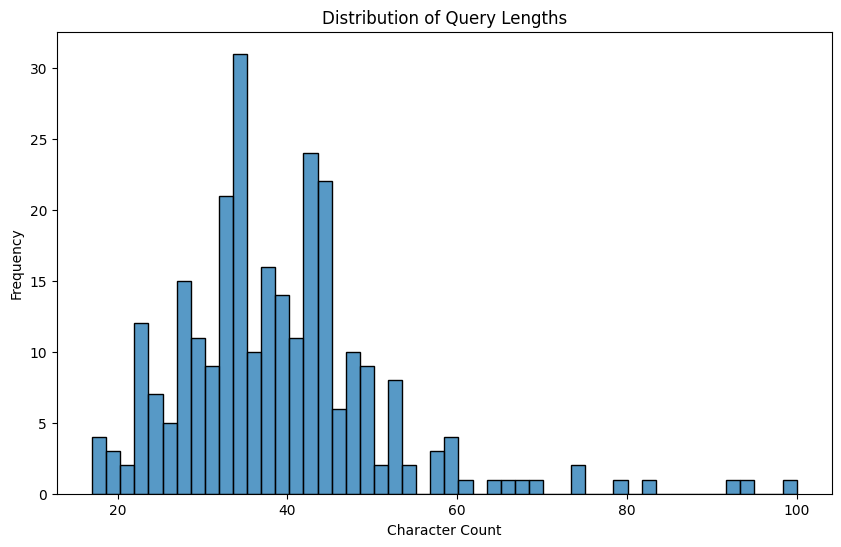


Queries with numbers: 273 (100.0%)

Queries with units: 76 (27.8%)

Most common units in queries:
mm        64
metros    18
kg         7
pieza      7
m          5
metro      2
piezas     1
Name: count, dtype: int64


In [ ]:
def analyze_queries(queries_df):
    """Analyze the query data to understand what customers are asking for"""
    print(f"Query dataset has {len(queries_df)} entries")

    # Identify the query column
    query_column = 'query' if 'query' in queries_df.columns else queries_df.columns[0]

    # Analyze query lengths
    queries_df['query_length'] = queries_df[query_column].str.len()

    plt.figure(figsize=(10, 6))
    sns.histplot(queries_df['query_length'], bins=50)
    plt.title('Distribution of Query Lengths')
    plt.xlabel('Character Count')
    plt.ylabel('Frequency')
    plt.show()

    # Extract numbers from queries
    queries_df['numbers'] = queries_df[query_column].str.findall(r'\d+').apply(lambda x: [int(i) for i in x] if len(x) > 0 else [])
    queries_df['has_numbers'] = queries_df['numbers'].apply(lambda x: len(x) > 0)

    print(f"\nQueries with numbers: {queries_df['has_numbers'].sum()} ({queries_df['has_numbers'].mean()*100:.1f}%)")

    # Extract common units
    unit_patterns = r'\b(pcs|pc|piezas|pieza|kg|kilos|kilogramos|m|metros|metro|mm|milímetros|milimetro|cm|centímetros|centimetro)\b'
    queries_df['units'] = queries_df[query_column].str.findall(unit_patterns, flags=re.IGNORECASE)
    queries_df['has_units'] = queries_df['units'].apply(lambda x: len(x) > 0)

    print(f"\nQueries with units: {queries_df['has_units'].sum()} ({queries_df['has_units'].mean()*100:.1f}%)")

    # Most common units
    all_units = [unit.lower() for units in queries_df['units'] for unit in units]
    unit_freq = pd.Series(all_units).value_counts()

    print("\nMost common units in queries:")
    print(unit_freq)

    return unit_freq

print("\nAnalyzing query patterns:")
unit_frequency = analyze_queries(queries_df)

> 🔸 Understanding the analysis:
*   Every query (273 total) includes numbers, used for quantities, dimensions, or measurements.
*   Only about 28% (76 queries) explicitly mention units and Millimeters (mm) is the most common (64 occurrences).
*   Length units appear most frequently (89 total, including variations like m, metro, metros).
*   Weight (kg) and count units (pieza/piezas) are much less common.

> So, the model must accurately differentiate numbers representing quantities from those specifying dimensions. It should infer default units for dimensions when they are not explicitly provided and incorporating unit conversion or normalization (e.g., converting metros to m) could be necessary. Also, when extracting product details the emphasis should be on dimensional matching.

# 🔸 VECTOR DATABASE CREATION

This section creates a searchable vector database that enables both semantic similarity search and exact metadata matching.

> 🔸What it does:
- Processes each product in the catalog to prepare for efficient retrieval
- Extracts key information like dimensions, materials, and product types
- Creates embeddings that capture semantic meaning of descriptions
- Organizes everything in a searchable FAISS database

> 🔸Technical implementation:
- Embedding: Universal Sentence Encoder (TensorflowHub, 512 dimensions)
- Database: FAISS IndexFlatL2 for L2 distance computation
- Metadata extraction using regex patterns:
  - SKU prefix: ([A-Za-z0-9]+)([0-9]+)
  - Dimensions: (\d+(?:[.,]\d+)?)\s*[xX]\s*(\d+(?:[.,]\d+)?)\s*(?:[xX]\s*(\d+(?:[.,]\d+)?))?
  - Material codes: \b(?:A|AISI|SAE)?\s*(?:304|316|316L|316Ti|A36)\b
- Normalization of dimensions and material codes for consistent matching

In [ ]:
# @title Creating Vector Database
def create_vector_db(catalog_df, force_rebuild=False):
    if os.path.exists(DB_PATH) and not force_rebuild:
        print(f"Loading existing vector database from {DB_PATH}")
        embedding_function = TensorflowHubEmbeddings(model_url=EMBEDDING_MODEL)
        return FAISS.load_local(DB_PATH, embedding_function, allow_dangerous_deserialization=True)

    print("Creating new vector database...")
    embedding_function = TensorflowHubEmbeddings(model_url=EMBEDDING_MODEL)

    docs = catalog_df['description'].str.lower().tolist()

    # Metadata extraction
    metadatas = []
    for _, row in catalog_df.iterrows():

        # Extracting SKU patterns
        sku_pattern_match = re.search(r'([A-Za-z0-9]+)([0-9]+)', row['sku'])
        sku_prefix = sku_pattern_match.group(1) if sku_pattern_match else ''

        # Extracting dimensions from description
        dimension_patterns = re.findall(r'(\d+(?:[.,]\d+)?)\s*[xX]\s*(\d+(?:[.,]\d+)?)\s*(?:[xX]\s*(\d+(?:[.,]\d+)?))?',
                                       row['description'])

        # Normalizing dimensions
        normalized_dimensions = []
        for dim_match in dimension_patterns:
            norm_dims = []
            for dim in dim_match:
                if dim:
                    norm_dim = dim.replace(',', '.')
                    norm_dims.append(norm_dim)
            if norm_dims:
                normalized_dimensions.append('x'.join(norm_dims))

        # Extracting material codes
        material_pattern = r'\b(?:A|AISI|SAE)?\s*(?:304|316|316L|316Ti|A36)\b'
        material_matches = re.findall(material_pattern, row['description'], re.IGNORECASE)
        material_codes = []

        for match in material_matches:
            # Normalizing to a standard format (e.g., "304")
            norm_match = re.sub(r'^(?:A|AISI|SAE)?\s*', '', match, flags=re.IGNORECASE)
            material_codes.append(norm_match.strip())

        # Determining product type
        product_types = []
        for product in ['angulo', 'chapa', 'tubo', 'planchuela', 'brida', 'pletina']:
            if product in row['description'].lower():
                product_types.append(product)

        metadata = {
            "sku": row["sku"],
            "description": row["description"],
            "sku_prefix": sku_prefix,
            "dimensions": normalized_dimensions,
            "material_codes": material_codes,
            "product_types": product_types
        }
        metadatas.append(metadata)

    faiss_vectorstore = FAISS.from_texts(
        texts=docs,
        embedding=embedding_function,
        metadatas=metadatas
    )

    faiss_vectorstore.save_local(DB_PATH)
    print(f"Vector database created and saved to {DB_PATH}")

    return faiss_vectorstore

In [ ]:
# Creating the vector database
vectorstore = create_vector_db(catalog_df)

Creating new vector database...
Vector database created and saved to catalog_vectorstore


#🔸HYBRID SEARCH IMPLEMENTATION

The hybrid search function combines vector similarity with exact matching of critical product attributes to find the most relevant products.

> 🔸How it works:
- Retrieves initial candidates using vector similarity (semantic matching)
- Extracts key information from the query (dimensions, materials, product type)
- Scores each candidate based on multiple matching criteria
- Re-ranks results to prioritize exact dimension matches

> 🔸Technical details:
- Initial retrieval: top_k*2 candidates using FAISS nearest neighbors
- Score weighting:
  - Vector similarity: 20% (transformed with 1.0 / (1.0 + vector_score))
  - Dimension match: 40% (exact match = 1.0, partial match = 0.5)
  - Material match: 20% (binary scoring with normalization)
  - Product type match: 20% (binary scoring)
- Dimension matching includes comma/dot normalization for decimal separators
- Handles multiple dimension formats in a single query

In [ ]:
# Hybrid Search Function
def hybrid_search(query, vectorstore, top_k=5):
    """
    Perform hybrid search combining vector similarity with exact matching
    """
    # Fetching vector similarity results
    vector_results = vectorstore.similarity_search_with_score(query, k=top_k*2)  # Get more results initially

    # Extracting key information from the query
    query_lower = query.lower()

    # Extracting dimensions
    query_dimensions = re.findall(r'(\d+(?:[.,]\d+)?)\s*[xX]\s*(\d+(?:[.,]\d+)?)\s*(?:[xX]\s*(\d+(?:[.,]\d+)?))?',
                                 query_lower)

    # Normalizing dimensions
    normalized_query_dimensions = []
    for dim_match in query_dimensions:
        norm_dims = []
        for dim in dim_match:
            if dim:
                # Replace comma with dot for decimal separator
                norm_dim = dim.replace(',', '.')
                norm_dims.append(norm_dim)
        if norm_dims:
            normalized_query_dimensions.append('x'.join(norm_dims))

    # Extracting material codes
    query_material_codes = re.findall(r'\b(?:A|AISI|SAE)?\s*(?:304|316|316L|316Ti|A36)\b',
                                    query_lower, re.IGNORECASE)

    # Detecting product types
    query_product_types = []
    for product in ['angulo', 'chapa', 'tubo', 'planchuela', 'brida', 'pletina']:
        if product in query_lower:
            query_product_types.append(product)

    # Calculate additional match scores
    enhanced_results = []

    for doc, vector_score in vector_results:
        vector_similarity = 1.0 / (1.0 + vector_score)

        dimension_match = 0.0
        material_match = 0.0
        product_type_match = 0.0

        # Checking dimension matches
        doc_dimensions = doc.metadata.get('dimensions', [])
        for query_dim in normalized_query_dimensions:
            for doc_dim in doc_dimensions:
                if query_dim == doc_dim:  # Exact match
                    dimension_match = 1.0
                    break
                elif len(query_dim.split('x')) == len(doc_dim.split('x')):
                    query_parts = query_dim.split('x')
                    doc_parts = doc_dim.split('x')
                    matching_dims = sum(1 for q, d in zip(query_parts, doc_parts) if q == d)
                    if matching_dims / len(query_parts) >= 0.67:
                        dimension_match = 0.5  # Partial match
                        break

        # Checking material matches
        doc_materials = doc.metadata.get('material_codes', [])
        for query_material in query_material_codes:
            for doc_material in doc_materials:
                if query_material.lower() in doc_material.lower() or doc_material.lower() in query_material.lower():
                    material_match = 1.0
                    break

        # Checking product type matches
        doc_product_types = doc.metadata.get('product_types', [])
        for query_type in query_product_types:
            if query_type in doc_product_types:
                product_type_match = 1.0
                break

        # Combined score
        combined_score = (
            0.2 * vector_similarity +
            0.4 * dimension_match +   # Highest weight for dimensions
            0.2 * material_match +
            0.2 * product_type_match
        )

        enhanced_results.append((doc, combined_score))

    # Sort by combined score (descending)
    enhanced_results.sort(key=lambda x: x[1], reverse=True)

    # Return top_k results
    return [doc for doc, _ in enhanced_results[:top_k]]

#🔸ORDER DETAILS EXTRACTION

This function leverages an LLM to analyze customer queries and identify the correct product along with order quantities and specifications.

> 🔸What it does:
- Takes in a customer query and candidate products from hybrid search
- Provides context about each candidate product to the LLM
- Extracts the exact SKU, quantity, and other order details
- Returns a structured representation of the order

> 🔸Technical implementation:
- Model: Llama-3.3-70B-Instruct-Turbo-Free with temperature 0.5
- Prompt engineering techniques:
  - Role-based instruction as a metalworking company assistant
  - 8 annotated examples with explicit reasoning traces
  - Clear instructions about dimension and material handling
  - JSON output format specification with typed fields
- Output fields: sku, items_count, mass_units, length_units, length, mass
- Error handling for malformed LLM responses with regex JSON extraction

In [ ]:
def extract_order_details(query, top_matches, translated=False):
    """
    Extract order details with comprehensive prompt engineering
    """
    # Format matches for LLM context with metadata
    matches_context = "\n".join([
        f"SKU: {match.metadata['sku']}, " +
        f"Descripción: {match.page_content}, " +
        f"Dimensiones: {', '.join(match.metadata.get('dimensions', []))}, " +
        f"Material: {', '.join(match.metadata.get('material_codes', []))}, " +
        f"Tipo: {', '.join(match.metadata.get('product_types', []))}"
        for match in top_matches
    ])

    # Add translated context if requested
    if translated:
        translated_context = "\n".join([
            f"SKU: {match.metadata['sku']}, " +
            f"Description: {translate_text(match.page_content)}, " +
            f"Dimensions: {', '.join(match.metadata.get('dimensions', []))}, " +
            f"Material: {', '.join(match.metadata.get('material_codes', []))}, " +
            f"Type: {', '.join(match.metadata.get('product_types', []))}"
            for match in top_matches
        ])
        matches_context += "\n\nTranslated Matches:\n" + translated_context

    # Prompts
    prompt = f"""
    Eres un asistente especializado para una empresa metalúrgica. Tu tarea es analizar pedidos de clientes y encontrar el producto exacto del catálogo que corresponde.

    CONSULTA DEL CLIENTE:
    {query}

    POSIBLES COINCIDENCIAS DEL CATÁLOGO (ordenadas por relevancia):
    {matches_context}

    INSTRUCCIONES IMPORTANTES:
    1. Las dimensiones son CRÍTICAS para identificar el producto correcto. Presta máxima atención a patrones como "20x20x3mm", "30 x 1.5", o fracciones como "1/2 x 1/8".
    2. Para ángulos (angulos), chapas, tubos y planchuelas, las dimensiones deben coincidir EXACTAMENTE con el catálogo.
    3. Los códigos de materiales pueden aparecer en diferentes formatos (A304, AISI 304, 304) - todos se refieren al mismo material.
    4. Los términos "brida" y "pletina" son productos específicos, no los confundas con otros.
    5. Cuando veas medidas con "L=" o "largo", esto se refiere a la longitud total solicitada.
    6. Guía de prefijos SKU: chapas (111/112), tubos (11), ángulos (27), planchuelas (15), pletinas (24), bridas (30).
    7. Si el producto no específica material pero menciona "inox", asume que es A304.
    8. Para convertir fracciones a decimales: 1/8 = 0.125, 1/4 = 0.25, 3/8 = 0.375, 1/2 = 0.5, 5/8 = 0.625, 3/4 = 0.75, 7/8 = 0.875.
    9. La PRIMERA coincidencia suele ser la más relevante - examínala cuidadosamente antes de considerar otras.

    Basándote en la consulta del cliente y las posibles coincidencias del catálogo, identifica:
    1. El SKU que mejor coincide con la solicitud del cliente (esto es lo más importante)
    2. La cantidad exacta que se está pidiendo (items_count)
    3. Las unidades de masa si se indican (mass_units, como "kg" o null)
    4. Las unidades de longitud si se indican (length_units, como "m" o null)
    5. El valor de longitud si se indica (length como número o null)
    6. El valor de masa si se indica (mass como número o null)

    EJEMPLOS DE ANÁLISIS (incluyen casos especiales):

    Ejemplo 1: "angulo inox a304 20x20x3mm= 24 mts"
    Pensamiento: La consulta pide un ángulo inoxidable A304 con dimensiones 20x20x3mm y longitud total de 24 metros. Las dimensiones coinciden exactamente con un ángulo de SKU 2714020020003.
    Respuesta: SKU: 2714020020003, items_count: 1, mass_units: null, length_units: "m", length: 24.0, mass: null

    Ejemplo 2: "15 chapas aisi 304 2b + pvc de 3000x1500x1,5"
    Pensamiento: La consulta pide 15 chapas de acero inoxidable AISI 304 2B con PVC, de dimensiones 3000x1500x1,5mm. La coma representa el decimal. El PVC indica un revestimiento especial. El SKU 111P30150015 coincide con estas especificaciones.
    Respuesta: SKU: 111P30150015, items_count: 15, mass_units: null, length_units: null, length: null, mass: null

    Ejemplo 3: "necesito tubo estructural rectangular 60 x 40 x 1,6 mm"
    Pensamiento: Se solicita tubo estructural rectangular con dimensiones 60x40x1,6mm. Es importante notar la forma rectangular y las dimensiones exactas. El SKU 1104060040016 coincide con estas especificaciones.
    Respuesta: SKU: 1104060040016, items_count: 1, mass_units: null, length_units: null, length: null, mass: null

    Ejemplo 4: "5 bridas de 2 pulgadas"
    Pensamiento: El cliente pide 5 bridas de 2 pulgadas. Las bridas se identifican por su diámetro. El SKU 3002000000002 corresponde a bridas de 2 pulgadas.
    Respuesta: SKU: 3002000000002, items_count: 5, mass_units: null, length_units: null, length: null, mass: null

    Ejemplo 5: "planchuela 1/2 x 1/8 hierro - 2 tiras de 6 metros"
    Pensamiento: El cliente solicita 2 tiras de planchuela de hierro con dimensiones en fracciones de pulgada: 1/2 x 1/8, cada una de 6 metros. Convertido a decimal: 0.5 x 0.125. El SKU 1503012700318 corresponde a esta planchuela.
    Respuesta: SKU: 1503012700318, items_count: 2, mass_units: null, length_units: "m", length: 6.0, mass: null

    Ejemplo 6: "planchuela de 1.1/2\" x 3/16\" x 6 metros - material A36 - cantidad: 10 tiras"
    Pensamiento: El cliente solicita 10 tiras de planchuela de material A36 con dimensiones mixtas: 1.1/2 pulgadas x 3/16 pulgadas x 6 metros. La notación 1.1/2" significa 1+1/2 = 1.5 pulgadas. El SKU 1503152000316 coincide con estas dimensiones para planchuela A36.
    Respuesta: SKU: 1503152000316, items_count: 10, mass_units: null, length_units: "m", length: 6.0, mass: null

    Ejemplo 7: "necesito 4 chapas galvanizadas de 0,5mm de espesor, 1,22 x 2,44 metros"
    Pensamiento: Se solicitan 4 chapas galvanizadas de 0,5mm de espesor con dimensiones 1,22 x 2,44 metros. Es importante notar el acabado galvanizado y convertir las dimensiones a milímetros: 1220x2440x0,5mm. El SKU 112G12240050 corresponde a chapa galvanizada con estas dimensiones.
    Respuesta: SKU: 112G12240050, items_count: 4, mass_units: null, length_units: null, length: null, mass: null

    Ejemplo 8: "tubo redondo inox 25,4mm (1\") diámetro, espesor 1,2mm - 12 metros en total"
    Pensamiento: El cliente pide tubo redondo inoxidable de 25,4mm (1 pulgada) de diámetro y 1,2mm de espesor, con una longitud total de 12 metros. El tubo redondo se especifica por diámetro externo y espesor. El SKU 1101025401200 corresponde a este tipo de tubo.
    Respuesta: SKU: 1101025401200, items_count: 1, mass_units: null, length_units: "m", length: 12.0, mass: null

    Devuelve tu respuesta ÚNICAMENTE en formato JSON sin explicaciones adicionales:
    {{
      "sku": "el SKU que mejor coincide",
      "items_count": número (la cantidad solicitada),
      "mass_units": "kg" o null si no aplica,
      "length_units": "m" o null si no aplica,
      "length": número o null,
      "mass": número o null
    }}
    """

    messages = [
        {"role": "system", "content": "Eres un asistente experto en identificar productos metalúrgicos a partir de descripciones en español. Tu especialidad es hacer coincidir exactamente las dimensiones y especificaciones técnicas."},
        {"role": "user", "content": prompt}
    ]

    client = Together(api_key=API_KEY)
    response = client.chat.completions.create(
        messages=messages,
        temperature=0.5,  # Lower temperature for more deterministic outputs
        model=LLM_MODEL
    )

    response_text = response.choices[0].message.content

    # Extract JSON from the response
    try:
        # Find JSON content in the response
        json_match = re.search(r'({[\s\S]*})', response_text)
        if json_match:
            result = json.loads(json_match.group(1))
            return result
        else:
            print(f"Failed to extract JSON from response: {response_text}")
            return None
    except Exception as e:
        print(f"Error parsing LLM response: {e}")
        print(f"Response was: {response_text}")
        return None

# 🔸QUERY PROCESSING PIPELINE

This function orchestrates the entire order processing workflow from raw customer queries to structured order information.

>🔸Pipeline steps:
- For each customer query, finds matching products using hybrid search
- Extracts detailed order information using the LLM
- Handles errors to ensure processing continues
- Returns a structured dataframe with all processed orders

>🔸Technical details:
- Configurable batch processing with optional size limits
- Query preprocessing: lowercase normalization
- Top-k retrieval (default: 5) to provide sufficient context
- Optional translation support for cross-language processing
- Error handling with placeholder generation for failed extractions
- Rate limiting (1-second delay) to prevent API throttling
- Comprehensive logging of processing status and errors

In [ ]:
def process_queries(queries_df, vectorstore, batch_size=None, top_k=5, translated=False):
    """Process queries using search and extraction functions"""
    # Identify the query column
    query_column = 'query' if 'query' in queries_df.columns else queries_df.columns[0]

    # Allow processing a subset for testing
    if batch_size and batch_size < len(queries_df):
        queries_to_process = queries_df.head(batch_size)
    else:
        queries_to_process = queries_df

    results = []

    for idx, row in tqdm(queries_to_process.iterrows(), total=len(queries_to_process)):
        query = row[query_column].lower()
        print(f"Processing query {idx+1}/{len(queries_to_process)}: {query[:50]}...")

        try:
            # Use hybrid search
            docs = hybrid_search(query, vectorstore, top_k=top_k)

            # Extract order details
            order_details = extract_order_details(query, docs, translated=translated)

            if order_details:
                # Add query to results
                order_details['query'] = row[query_column]
                # Add translated query if available
                if translated:
                    order_details['query_translated'] = translate_text(row[query_column])
                results.append(order_details)
            else:
                print(f"Failed to extract order details for query: {query}")
                # Add a placeholder result
                results.append({
                    'query': row[query_column],
                    'query_translated': translate_text(row[query_column]) if translated else None,
                    'sku': 'EXTRACTION_FAILED',
                    'items_count': None,
                    'mass_units': None,
                    'length_units': None,
                    'length': None,
                    'mass': None
                })
        except Exception as e:
            print(f"Error processing query: {e}")
            # Add a placeholder for failed processing
            results.append({
                'query': row[query_column],
                'sku': 'PROCESSING_ERROR',
                'items_count': None,
                'mass_units': None,
                'length_units': None,
                'length': None,
                'mass': None
            })

        # Add a small delay to avoid rate limiting
        time.sleep(1)

    return pd.DataFrame(results)

#🔸PERFORMANCE EVALUATION

This function evaluates how well the system matches customer queries to the correct products by comparing against ground truth data.

>🔸What it measures:
- Accuracy of SKU matching (correct product identification)
- Precision, recall, and F1 score of the matching process
- Detailed error analysis to identify improvement opportunities

>🔸Technical implementation:
- Dynamic column name detection with multiple fallbacks
- Type normalization (string conversion) for consistent comparison
- Exclusion of failed extractions (EXTRACTION_FAILED, PROCESSING_ERROR)
- Macro-averaging for precision/recall/F1 metrics
- Comprehensive error handling for edge cases:
  - Zero division in metric calculation
  - Missing columns in result or ground truth
  - Type mismatches between predicted and true values
- Detailed logging of evaluation process for transparency

In [ ]:
def evaluate_results(results_df, answers_df):
    """Evaluate the results against the ground truth answers with improved error handling"""
    if answers_df is None:
        print("No answers data available for evaluation")
        return None

    # Print column names for debugging
    print("Columns in answers_df:", answers_df.columns.tolist())
    print("Columns in results_df:", results_df.columns.tolist())

    if 'query' not in results_df.columns:
        print("Error: 'query' column not found in results_df")
        return None

    if 'sku' not in results_df.columns:
        print("Error: 'sku' column not found in results_df")
        # Try to find an alternative column
        for col in results_df.columns:
            if 'sku' in col.lower():
                print(f"Found alternative column: {col}")
                results_df['sku'] = results_df[col]
                break
        else:
            return None

    # Determine which column contains the true SKU values in answers_df
    sku_true_col = None
    for col_name in ['sku.1', 'sku_true', 'sku']:
        if col_name in answers_df.columns:
            sku_true_col = col_name
            print(f"Using '{sku_true_col}' from answers_df as ground truth SKU")
            break

    if sku_true_col is None:
        print("Error: Could not find the true SKU column in answers_df")
        print("Available columns are:", answers_df.columns.tolist())
        return None

    # Create a copy to avoid modifying the original dataframes
    results_df_copy = results_df.copy()
    answers_df_copy = answers_df.copy()

    # Print sample data to see format
    print("\nSample from results_df:")
    for col in ['query', 'sku']:
        if col in results_df_copy.columns:
            print(f"{col}: {results_df_copy[col].head(3).tolist()}")

    print("\nSample from answers_df:")
    for col in ['query', sku_true_col]:
        if col in answers_df_copy.columns:
            print(f"{col}: {answers_df_copy[col].head(3).tolist()}")

    # Ensure both dataframes have the query column as string type for merging
    results_df_copy['query'] = results_df_copy['query'].astype(str)
    answers_df_copy['query'] = answers_df_copy['query'].astype(str)

    try:
        # First check if there's any matching queries
        common_queries = set(results_df_copy['query']).intersection(set(answers_df_copy['query']))
        print(f"Number of common queries: {len(common_queries)}")

        if len(common_queries) == 0:
            print("No common queries found between results and answers!")
            # Try to find a sample match to debug
            print("\nSample queries from results_df:")
            print(results_df_copy['query'].head(3).tolist())
            print("\nSample queries from answers_df:")
            print(answers_df_copy['query'].head(3).tolist())
            return None

        # Merge on query column
        print(f"\nMerging on 'query' column...")
        merged = pd.merge(
            results_df_copy[['query', 'sku']],
            answers_df_copy[['query', sku_true_col]],
            on='query',
            how='inner'  # Only evaluate on queries that exist in both datasets
        )

        print(f"Merged shape: {merged.shape}")
        print("Merged dataframe columns:", merged.columns.tolist())

        if len(merged) == 0:
            print("Warning: Merge returned zero rows!")
            return None

        # Calculate accuracy
        try:
            # Convert to string for comparison to handle different types
            merged['sku'] = merged['sku'].astype(str)
            merged[sku_true_col] = merged[sku_true_col].astype(str)

            # Handling 'EXTRACTION_FAILED' or 'PROCESSING_ERROR' values
            valid_mask = ~((merged['sku'] == 'EXTRACTION_FAILED') |
                           (merged['sku'] == 'PROCESSING_ERROR'))

            if valid_mask.sum() == 0:
                print("No valid SKU predictions found!")
                return None

            # Accuracy
            matched = (merged['sku'] == merged[sku_true_col]) & valid_mask
            sku_accuracy = matched.sum() / valid_mask.sum()

            # Detailed statistics
            print(f"\nTotal evaluated queries: {valid_mask.sum()}")
            print(f"Correct predictions: {matched.sum()}")
            print(f"SKU Matching Accuracy: {sku_accuracy:.4f}")

            # Calculate precision, recall, F1
            try:
                from sklearn.metrics import precision_recall_fscore_support

                # Filter out invalid predictions
                valid_merged = merged[valid_mask].copy()

                # Get unique labels from both predicted and true values
                unique_labels = list(set(valid_merged[sku_true_col].unique()).union(
                                    set(valid_merged['sku'].unique())))

                precision, recall, f1, _ = precision_recall_fscore_support(
                    valid_merged[sku_true_col],
                    valid_merged['sku'],
                    average='macro',
                    zero_division=0,
                    labels=unique_labels
                )
                print(f"Precision: {precision:.4f}")
                print(f"Recall: {recall:.4f}")
                print(f"F1 Score: {f1:.4f}")
            except Exception as e:
                print(f"Warning: Could not calculate precision/recall metrics: {e}")
                import traceback
                traceback.print_exc()
                precision, recall, f1 = 0, 0, 0

            return {
                'sku_accuracy': sku_accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'total_evaluated': valid_mask.sum(),
                'correct_predictions': matched.sum()
            }

        except Exception as e:
            print(f"Error calculating metrics: {e}")
            import traceback
            traceback.print_exc()
            return None

    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()
        return None

In [ ]:
def run_processing(batch_size=None, force_fresh_processing=False):
    """Run the processing pipeline with optional batch size"""
    if 'queries_df' not in globals() or 'vectorstore' not in globals():
        print("Required data or vectorstore not loaded")
        return None

    # Determine how many queries to process
    if batch_size is not None and batch_size < len(queries_df):
        print(f"Processing batch of {batch_size} queries out of {len(queries_df)} total queries")
        queries_to_process = queries_df.head(batch_size).copy()
    else:
        print(f"Processing full dataset of {len(queries_df)} queries")
        queries_to_process = queries_df.copy()

    # Ensuring the model isn't using cached results
    if force_fresh_processing:
        process_id = int(time.time())
        print(f"Fresh processing ID: {process_id}")

        queries_to_process = queries_to_process.copy()
        if 'unique_id' not in queries_to_process.columns:
            queries_to_process['unique_id'] = [f"{process_id}_{i}" for i in range(len(queries_to_process))]

    start_time = time.time()

    # Process queries
    print("Processing queries...")
    results_df = process_queries(
        queries_to_process,
        vectorstore,
        top_k=5,
        translated=True
    )

    # Calculate processing time
    processing_time = time.time() - start_time
    print(f"Processing completed in {processing_time/60:.1f} minutes")

    # Evaluate results if answers are available
    if 'answers_df' in globals() and answers_df is not None:
        metrics = evaluate_results(results_df, answers_df)

        if metrics:
            print("\nPerformance metrics:")
            print(f"SKU Matching Accuracy: {metrics['sku_accuracy']:.4f}")
            print(f"Precision: {metrics['precision']:.4f}")
            print(f"Recall: {metrics['recall']:.4f}")
            print(f"F1 Score: {metrics['f1']:.4f}")

    return results_df

In [ ]:
# @markdown ⚠️ Please make sure to set these parameters before running the cell!
# @markdown > Checked: All queries will be processed  Unchecked: A smaller batch will be used for testing
process_full_dataset = True # @param {"type":"boolean","placeholder":"Process full dataset"}

# @markdown > Drag slider to set number of queries to process when not processing the full dataset

batch_size_input = 130  # @param {type:"slider", min:10, max:200, step:10}
# @markdown > If enabled, ignores cached results and forces re-processing

force_fresh_processing = True  # @param {type:"boolean"}

# Adding unique processing ID to prevent caching
if force_fresh_processing:
    processing_id = int(time.time())
    print(f"Forcing fresh processing (ID: {processing_id})")
else:
    processing_id = None

if process_full_dataset:
    print("Processing full dataset...")
    results_df = run_processing(batch_size=None)
else:
    print(f"Processing batch of {batch_size_input} queries...")
    results_df = run_processing(batch_size=batch_size_input)

# Summary of results
if 'results_df' in locals() and len(results_df) > 0:
    print(f"\nProcessed {len(results_df)} queries")
    print(f"Extraction failures: {(results_df['sku'] == 'EXTRACTION_FAILED').sum()}")
    print(f"Processing errors: {(results_df['sku'] == 'PROCESSING_ERROR').sum()}")

    # Save results with processing ID to distinguish between runs
    if force_fresh_processing and processing_id:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        results_filename = f'/content/results_{timestamp}_{processing_id}.csv'
        results_df.to_csv(results_filename, index=False)
        print(f"Results saved to: {results_filename}")

Forcing fresh processing (ID: 1744657600)
Processing full dataset...
Processing full dataset of 273 queries
Processing queries...


  0%|          | 0/273 [00:00<?, ?it/s]

Processing query 1/273: angulo inox a304 20x20x3mm= 24 mts,...
Processing query 2/273: 1 angulo 25x25x1.5 aisi 304 lc,...
Processing query 3/273: angulo inox a304 25x25x3mm = 24 mts, lc...
Processing query 4/273: angulo l.c. aisi304 25x25x3 mm...
Processing query 5/273: 1 ud angulo en acero inoxidable de 316 de x 25x25x...
Processing query 6/273: angulo inox a304 30x30x3mm = 24 mts,...
Processing query 7/273: 1 angulo 30x3 aisi 304...
Processing query 8/273: 1 angulo 40x40x4 aisi 304 lc,...
Processing query 9/273: angulo inox a304 40x40x4mm = 24 mts,...
Processing query 10/273: 1 paq. angulo 40x40x4 a-304,...
Processing query 11/273: perfil angular 40x40x4 inox...
Processing query 12/273: 5. ã¡ngulo 50x50x5 inox304,...
Processing query 13/273: 1 paq. angulo 50x50x5 a-304,...
Processing query 14/273: angulo inox a304 30x30x1mm pulido = 60 mts,...
Processing query 15/273: angulo inox a304 40x40x1,5mm pulido = 6 mts,...
Processing query 16/273: brida plana en-1092-1 type 1 pn-10 dn600 a-3

# Bonus Challenge

# EMAIL GENERATION AND PARSING

This section tackles the more realistic scenario of processing unstructured customer emails rather than simple queries.

>🔸Challenge overview:
- Generate realistic customer emails ordering catalog products
- Extract structured order information from these informal emails
- Evaluate the system's performance on this more complex task

>🔸Technical implementation:
- Email generation using LLM with three complexity levels:
  - Simple: Direct product requests with minimal context
  - Medium: Professional format with inquiries about availability/delivery
  - Complex: Detailed with additional context, questions, and multiple products
- Two-stage email parsing:
  1. Segment identification: Locate individual product mentions
  2. Per-segment processing: Apply hybrid search and order extraction
- JSON-based intermediate representations for structured processing
- Evaluation metrics: precision, recall, F1 score against ground truth
- Error analysis focused on false positives and false negatives

In [ ]:
import pandas as pd
import numpy as np
import random
import json
import re
from tqdm.notebook import tqdm
import time
from together import Together
import os

In [ ]:
def generate_email_prompt(selected_items, complexity='medium'):
    """
    Parameters:
    - selected_items: List of dictionaries with product details
    - complexity: 'simple', 'medium', or 'complex'
    """
    # Format the items for the prompt
    items_text = "\n".join([
        f"- SKU: {item['sku']}, Descripción: {item['description']}"
        for item in selected_items
    ])

    # Define complexity characteristics
    complexity_guide = {
        'simple': "El email debe ser directo y breve, solicitando exactamente los productos listados.",
        'medium': "El email debe tener un tono profesional con una introducción y cierre. Incluye alguna pregunta sobre disponibilidad o entrega.",
        'complex': "El email debe ser detallado, con introducciones, comentarios adicionales, preguntas sobre precios, disponibilidad, alternativas, referencias a pedidos anteriores y posibles descuentos. Incluye también algún detalle irrelevante para hacer el email más natural."
    }

    prompt = f"""
    Genera un email realista en español de un cliente pidiendo productos metalúrgicos. El email debe parecer un mensaje real que un cliente enviaría a un proveedor de productos metalúrgicos.

    PRODUCTOS A INCLUIR EN EL EMAIL:
    {items_text}

    INSTRUCCIONES ESPECÍFICAS:
    1. {complexity_guide[complexity]}
    2. El email debe incluir TODOS los productos listados con sus dimensiones exactas.
    3. Para cada producto, incluye una cantidad aleatoria (entre 1 y 20).
    4. Para algunos productos (no todos), agrega detalles como longitud (en metros) o peso (en kg).
    5. Usa un formato y estilo realista de un email comercial en español.
    6. El email debe estar firmado por un nombre español ficticio, con alguna información de contacto y nombre de empresa.
    7. IMPORTANTE: No menciones los códigos SKU en el email, solo las descripciones de los productos.
    8. Incluye errores tipográficos leves y expresiones coloquiales para hacerlo más auténtico.

    EJEMPLOS DE CÓMO REFERIRSE A LOS PRODUCTOS (no copies exactamente):
    - "Necesitamos 5 tubos cuadrados 40x40x2mm en acero inoxidable 304"
    - "Por favor envíen 10 metros de planchuela 1 1/2 x 3/16"
    - "Solicito presupuesto para 3 chapas de acero inoxidable 316L de 2000x1000x1,5mm"

    Genera ÚNICAMENTE el cuerpo del email, sin líneas de asunto ni encabezados de email (To:, From:, etc).
    """

    return prompt

In [ ]:
def select_random_items(catalog_df, min_items=1, max_items=4):
    #Select random items from the catalog
    num_items = random.randint(min_items, max_items)
    selected_indices = random.sample(range(len(catalog_df)), num_items)

    selected_items = []
    for idx in selected_indices:
        item = {
            'sku': catalog_df.iloc[idx]['sku'],
            'description': catalog_df.iloc[idx]['description']
        }
        selected_items.append(item)

    return selected_items

In [ ]:
def generate_email(selected_items, client, complexity='medium'):
    """Generate an email ordering the selected items"""
    prompt = generate_email_prompt(selected_items, complexity)

    messages = [
        {"role": "system", "content": "Eres un asistente que genera emails realistas en español para pedidos de productos metalúrgicos."},
        {"role": "user", "content": prompt}
    ]

    try:
        response = client.chat.completions.create(
            messages=messages,
            temperature=0.8,  # Higher temperature for creativity
            model=LLM_MODEL,
            max_tokens=1000
        )

        email_text = response.choices[0].message.content
        return email_text
    except Exception as e:
        print(f"Error generating email: {e}")
        return None

In [ ]:
def generate_email_dataset(catalog_df, num_emails=20, client=None):
    """Generate a dataset of emails with corresponding ground truth"""
    if client is None:
        client = Together(api_key=API_KEY)

    emails = []
    ground_truth = []

    complexities = ['simple', 'medium', 'complex']

    for i in tqdm(range(num_emails)):
        # Select random complexity
        complexity = random.choice(complexities)

        # Select random items
        selected_items = select_random_items(catalog_df,
                                            min_items=1,
                                            max_items=3 if complexity == 'simple' else 4)

        # Generate email
        email_text = generate_email(selected_items, client, complexity)

        if email_text:
            emails.append({
                'email_id': i + 1,
                'email_text': email_text,
                'complexity': complexity
            })

            for item in selected_items:
                ground_truth.append({
                    'email_id': i + 1,
                    'sku': item['sku'],
                    'description': item['description']
                })

        time.sleep(1)

    emails_df = pd.DataFrame(emails)
    ground_truth_df = pd.DataFrame(ground_truth)

    return emails_df, ground_truth_df

In [ ]:
def extract_order_segments(email_text, client):
    """Extract segments of text that contain product orders"""
    prompt = f"""
    A continuación hay un email de un cliente solicitando productos metalúrgicos. Tu tarea es identificar cada segmento de texto que mencione un producto específico.

    EMAIL DEL CLIENTE:
    {email_text}

    INSTRUCCIONES:
    1. Identifica cada mención de un producto metalúrgico en el email.
    2. Para cada producto, extrae la frase completa que lo menciona, incluyendo cualquier detalle sobre cantidades, dimensiones, materiales, etc.
    3. Cada segmento debe contener información sobre UN SOLO producto.
    4. Ignora partes del email que no mencionan productos (saludos, información de contacto, etc).

    Devuelve ÚNICAMENTE un array JSON con los segmentos identificados, sin explicaciones adicionales:
    ["segmento 1", "segmento 2", ...]
    """

    messages = [
        {"role": "system", "content": "Eres un asistente especializado en análisis de textos para identificar menciones de productos metalúrgicos."},
        {"role": "user", "content": prompt}
    ]

    try:
        response = client.chat.completions.create(
            messages=messages,
            temperature=0.3,
            model=LLM_MODEL
        )

        response_text = response.choices[0].message.content

        # Extract JSON array from the response
        json_match = re.search(r'(\[[\s\S]*\])', response_text)
        if json_match:
            segments = json.loads(json_match.group(1))
            return segments
        else:
            print(f"Failed to extract segments from response: {response_text}")
            return []
    except Exception as e:
        print(f"Error extracting segments: {e}")
        return []

In [ ]:
def parse_email_with_llm(email_text, vectorstore, client=None, top_k=5):
    """Parse an email to extract product orders using hybrid search and LLM"""
    if client is None:
        client = Together(api_key=API_KEY)

    # Step 1: Extract potential order segments from the email
    segments = extract_order_segments(email_text, client)
    if not segments:
        print(f"No order segments found in email")
        return []

    # Step 2: Process each segment to identify products and details
    parsed_orders = []

    for segment in segments:
        # Using hybrid search again to find matching products
        try:
            docs = hybrid_search(segment, vectorstore, top_k=top_k)

            if docs:
                order_details = extract_order_details(segment, docs, translated=False)

                if order_details and 'sku' in order_details and order_details['sku'] != 'EXTRACTION_FAILED':
                    parsed_orders.append(order_details)
        except Exception as e:
            print(f"Error processing segment '{segment[:50]}...': {e}")

    return parsed_orders

In [ ]:
def process_email_dataset(emails_df, vectorstore, client=None, sample_size=None):
    """Process a dataset of emails to extract orders"""
    if client is None:
        client = Together(api_key=API_KEY)

    # Allow processing a subset for testing
    if sample_size and sample_size < len(emails_df):
        emails_to_process = emails_df.sample(n=sample_size, random_state=42)
    else:
        emails_to_process = emails_df

    all_orders = []

    for idx, row in tqdm(emails_to_process.iterrows(), total=len(emails_to_process)):
        email_id = row['email_id']
        email_text = row['email_text']

        print(f"\nProcessing email {email_id}...")

        try:
            orders = parse_email_with_llm(email_text, vectorstore, client)

            if orders:
                for order in orders:
                    # Add email_id to each order
                    order['email_id'] = email_id
                    all_orders.append(order)
            else:
                print(f"No orders found in email {email_id}")
        except Exception as e:
            print(f"Error processing email {email_id}: {e}")

        # Small delay to avoid rate limiting
        time.sleep(1)

    return pd.DataFrame(all_orders)

In [ ]:
def evaluate_email_parsing(parsed_orders_df, ground_truth_df):
    """Evaluate the performance of email parsing against ground truth"""
    if len(parsed_orders_df) == 0:
        print("No parsed orders to evaluate")
        return None

    # Merge parsed orders with ground truth on email_id and sku
    merged = pd.merge(parsed_orders_df, ground_truth_df,
                      on=['email_id', 'sku'],
                      how='outer',
                      indicator=True)

    # Calculate metrics
    true_positives = len(merged[merged['_merge'] == 'both'])
    false_positives = len(merged[merged['_merge'] == 'left_only'])
    false_negatives = len(merged[merged['_merge'] == 'right_only'])

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\nEmail Parsing Evaluation:")
    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Analyze errors
    if false_positives > 0:
        print("\nFalse Positive Examples (Incorrectly identified):")
        fp_examples = merged[merged['_merge'] == 'left_only'].head(3)
        for idx, row in fp_examples.iterrows():
            print(f"Email ID: {row['email_id']}, Identified SKU: {row['sku']}")

    if false_negatives > 0:
        print("\nFalse Negative Examples (Missed items):")
        fn_examples = merged[merged['_merge'] == 'right_only'].head(3)
        for idx, row in fn_examples.iterrows():
            print(f"Email ID: {row['email_id']}, Missed SKU: {row['sku']}")

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
def run_email_pipeline(catalog_df, num_emails=10, sample_size=None, regenerate=True):
    """Run the entire email generation and parsing pipeline"""
    client = Together(api_key=API_KEY)

    # Step 1: Generate email dataset
    emails_file = 'generated_emails.csv'
    ground_truth_file = 'email_ground_truth.csv'

    if regenerate or not os.path.exists(emails_file):
        print(f"Generating {num_emails} emails...")
        emails_df, ground_truth_df = generate_email_dataset(catalog_df, num_emails, client)

        # Save to CSV
        emails_df.to_csv(emails_file, index=False)
        ground_truth_df.to_csv(ground_truth_file, index=False)
        print(f"Generated emails saved to {emails_file}")
        print(f"Ground truth saved to {ground_truth_file}")
    else:
        print(f"Loading existing emails from {emails_file}")
        emails_df = pd.read_csv(emails_file)
        ground_truth_df = pd.read_csv(ground_truth_file)

    # Display sample email
    print("\nSample Generated Email:")
    sample_email = emails_df.iloc[0]['email_text']
    print("="*50)
    print(sample_email)
    print("="*50)

    # Step 2: Process emails to extract orders
    print("\nProcessing emails to extract orders...")
    parsed_orders_df = process_email_dataset(emails_df, vectorstore, client, sample_size)

    # Save parsed orders
    parsed_orders_file = 'parsed_email_orders.csv'
    parsed_orders_df.to_csv(parsed_orders_file, index=False)
    print(f"Parsed orders saved to {parsed_orders_file}")

    # Step 3: Evaluate results
    metrics = evaluate_email_parsing(parsed_orders_df, ground_truth_df)

    return emails_df, ground_truth_df, parsed_orders_df, metrics

In [ ]:
# Set parameters

# @markdown >⚠️ Use the slider to set the umber of emails to be generated
num_emails = 20 # @param {type:"slider", min:10, max:100, step:10}
sample_size = None  # Process all generated emails
# @markdown > 📧 Regeneration of emails:

# @markdown > Checked: Regenerates a fresh batch of emails

# @markdown > Unchecked: Uses cached results if available

regenerate = True # @param {type:"boolean"}

# Run the pipeline
emails_df, ground_truth_df, parsed_orders_df, metrics = run_email_pipeline(
    catalog_df,
    num_emails=num_emails,
    sample_size=sample_size,
    regenerate=regenerate
)

# Display summary
print("\nEmail Processing Summary:")
print(f"Generated {len(emails_df)} emails with {len(ground_truth_df)} products")
print(f"Extracted {len(parsed_orders_df)} products from emails")
print(f"F1 Score: {metrics['f1']:.4f}")

# Display sample results
print("\nSample Parsed Orders:")
display(parsed_orders_df.head())

Generating 20 emails...


  0%|          | 0/20 [00:00<?, ?it/s]

Generated emails saved to generated_emails.csv
Ground truth saved to email_ground_truth.csv

Sample Generated Email:
Estimados,

Me dirijo a ustedes para solicitar un presupuesto detallado para una serie de productos metalúrgicos que necesitamos con urgencia para un proyecto que estamos a punto de iniciar. Como ya saben, hemos trabajado juntos en varias ocasiones anteriores y siempre hemos quedado satisfechos con la calidad de sus productos y el servicio que ofrecen.

En esta ocasión, necesitamos 10 tubos inoxidable pulido A304 de 100x100x4mm. Me gustaría saber si tienen stock disponible de estos tubos y si podrían enviarme un presupuesto con los precios actuales. También me interesaría saber si hay alguna opción de descuento para compras en grandes cantidades, ya que estamos considerando ampliar nuestro pedido en el futuro.

Además, me gustaría preguntar sobre la posibilidad de obtener una longitud específica para estos tubos. Necesitamos 5 metros de longitud para cada tubo, ¿sería po

  0%|          | 0/20 [00:00<?, ?it/s]


Processing email 1...

Processing email 2...

Processing email 3...

Processing email 4...

Processing email 5...

Processing email 6...

Processing email 7...

Processing email 8...

Processing email 9...

Processing email 10...

Processing email 11...

Processing email 12...

Processing email 13...

Processing email 14...

Processing email 15...

Processing email 16...

Processing email 17...

Processing email 18...

Processing email 19...

Processing email 20...
Parsed orders saved to parsed_email_orders.csv

Email Parsing Evaluation:
True Positives: 44
False Positives: 24
False Negatives: 11
Precision: 0.6471
Recall: 0.8000
F1 Score: 0.7154

False Positive Examples (Incorrectly identified):
Email ID: 1, Identified SKU: 115490250100
Email ID: 1, Identified SKU: 341303015
Email ID: 3, Identified SKU: 355103001515

False Negative Examples (Missed items):
Email ID: 4, Missed SKU: 115220100040
Email ID: 5, Missed SKU: 345103010
Email ID: 6, Missed SKU: 111140150020

Email Processing Su

,sku,items_count,mass_units,length_units,length,mass,email_id
0,341210040,10.0,None,None,NaN,NaN,1
1,341303015,1.0,None,m,5.0,NaN,1
2,115490250100,1.0,None,None,NaN,NaN,1
3,3311025012,10.0,None,m,6.0,NaN,2
4,3L11402015,5.0,kg,None,NaN,2.0,2


## 📂 CONCLUSION AND RESULTS

This project tackled the challenge of automating metal product ordering using NLP and machine learning. The system achieved promising baseline results with clear opportunities for better performance with refinement.

### 📊 System Performance

**Main Task – SKU Matching:**

>On 273 Queries -

- Accuracy: 71.20%  
- Precision: 54.17%  
- Recall: 52.94%  
- F1 Score: 52.79%

**Bonus Task – Email Parsing:**

>On a batch of 20 emails -

- Precision: 64.71%  
- Recall: 80.00%  
- F1 Score: 71.54%

A 71% SKU matching accuracy is a respectable baseline. However, the lower F1 score indicates that prediction consistency varies across product types. Interestingly, the system performed decently on the more complex email parsing task, likely due to the additional context available in longer emails.

### 🌍 Language and Domain Considerations

Since I am not a Spanish speaker, I used large language models to help with translation, domain-specific terminology, and prompt generation. This allowed me to understand catalog entries and queries effectively, bridging the language gap. Translation also played a key role in prompt tuning and error analysis.

### ⚙️ Implementation Challenges

- Spanish regional expressions and informal units were difficult to normalize  
- Parsing fractional dimensions like "1/2" alongside decimal formats was tricky  
- Colab's caching behavior occasionally made repetitive testing inconsistent

### 🤖 Model Comparison

Although Mixtral 8x7B is known for strong multilingual performance (including Spanish), Llama-3.3-70B delivered better results for SKU matching and technical attribute extraction in this domain when tested on the same batch of queries. This highlighted the importance of effective prompt engineering, where small changes often had a greater impact than algorithmic tweaks to the search logic.

### 🔁 Future Improvements

- Improve dimension normalization for mixed unit formats and industry-specific formats
- Dedicated preprocessing for regional Spanish variants and informal measurements  
- Include  Confidence scoring to flag uncertain predictions for human review  
- Create a feedback loop to fine-tune the system with corrected outputs  

This project shows that even without domain-specific training and limited training data, a functioning system can be built using general-purpose LLMs and structured query processing. Improving performance beyond the current level i.e.getting from 70% to 90%+ accuracy would likely require significant domain-specific customization.

>💡If I had more time, I would improve the recall and precision of SKU matching by implementing better logic for unit inference, refining dimension extraction, and adding validation rules after LLM predictions.